# Analysis

In [1]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

In [2]:
sns.set(rc={'figure.figsize':(10,7)})
plt.style.use('seaborn-whitegrid')

In [3]:
year = '19'

## Data preparation

In [39]:
f = uproot.pandas.iterate("../outputs/"+year+"/trees/*.root", "t", reportpath = True,
                          branches=['beam_energy', 'mass', 'trigger', 'procedure'])

In [40]:
dataRAW = pd.concat([j.assign(name=float(re.findall(r"\d+\.\d+", path)[0])) for path,j in f])

In [41]:
dataRAW.sort_values(by='name', ascending=True, inplace=True);

Количество уникальных `name` в `data` должно совпадать с количеством точек в сезоне
* 17 год: 34 точки
* 19 год: 44 точки

In [42]:
print("Checking:", len(dataRAW.name.unique()), 'different names in', year, 'season')

Checking: 44 different names in 19 season


Проверка типов полей датафрейма

In [43]:
dataRAW.dtypes

beam_energy    float64
mass           float64
trigger          int32
procedure        int32
name           float64
dtype: object

Проверка данных

In [44]:
dataRAW.describe()

,beam_energy,mass,trigger,procedure,name
count,11694.000000,11694.000000,11694.000000,11694.00000,11694.000000
mean,651.900716,459.723651,1.689499,2.19805,652.055208
std,127.437707,133.473930,0.683433,0.55896,127.402987
min,537.454102,-1.000000,-1.000000,1.00000,537.500000
25%,549.341187,491.805504,2.000000,2.00000,550.000000
50%,599.889893,496.599579,2.000000,2.00000,600.000000
75%,762.798401,500.710320,2.000000,3.00000,762.000000
max,987.804626,577.373352,2.000000,3.00000,987.500000


Проверить триггер

In [45]:
bad_trig = dataRAW.query('trigger<0')
print('Energy points with bad trigger:\n', bad_trig.name.value_counts())

Energy points with bad trigger:
 837.5    2
812.5    2
775.0    2
737.5    2
662.5    2
637.5    2
925.0    1
887.5    1
875.0    1
850.0    1
800.0    1
750.0    1
725.0    1
550.0    1
Name: name, dtype: int64


Проверить энергии

In [46]:
bad_en = dataRAW.query('beam_energy<0')
print('Bad energy records:', bad_en.name.shape[0])

Bad energy records: 0


Удалить события с плохим триггером и энергиями (не в моделировании)

In [47]:
data = dataRAW if 'model' in year else dataRAW.query('trigger>-1&beam_energy>0')

Оставить только массы внутри окна (450,550) и без процедуры kinfit

In [48]:
data = data.query('mass>450&mass<550&procedure!=1')

In [49]:
print(data.shape[0], 'records left')

10580 records left


Удалить ненужные столбцы

In [50]:
data.drop(['procedure'], axis=1, inplace=True)

In [51]:
data.head()

,beam_energy,mass,trigger,name
0,537.454102,496.262360,2,537.5
1379,537.454102,497.135071,2,537.5
1378,537.454102,496.744629,2,537.5
1377,537.454102,497.835114,0,537.5
1376,537.454102,494.808807,2,537.5


Добавить светимости

In [68]:
lum = pd.read_csv(f'../inputs/{year}/lum.dat')
lum.rename({'label': 'name'}, axis=1, inplace=True)
if 'err' in lum.columns:
    lum.drop(['err'], axis=1, inplace=True) #ошибка светимостей уходит в систематику
    
lum = lum.sort_values(by='name')

In [90]:
lum.tail()

,name,lum
39,955.0,1254.610
35,962.5,2004.700
37,975.0,3972.320
36,978.0,451.273
38,987.5,2272.430


Проверить данные (хорошо, если числа совпадают)

Если не совпадают, то проверить светимости на дубликаты

In [70]:
print('Records in  lum:', lum.shape[0])
print('Records in data:', data.name.unique().shape[0])

Records in  lum: 44
Records in data: 44


Объединить данные и светимость

In [329]:
data_prep = lum.merge(data, on='name')

In [330]:
def check_foo(data1, data2):
    if(data1.shape[0] == data2.shape[0]):
        print("Good.", data1.shape[0], 'rows' )
    else:
        print("WARNING. frames haven't equal shape |", data1.shape[0], 'vs', data2.shape[0], 'records')
    return

In [331]:
check_foo(data_prep, data)

Good. 10580 rows


Смотрим, в каких именно точках не совпадают `data` и `lum`

In [332]:
set1 = set(data.name.unique())
set2 = set(lum.name.unique())

(set1|set2).difference(set1&set2)

set()

### Pictures

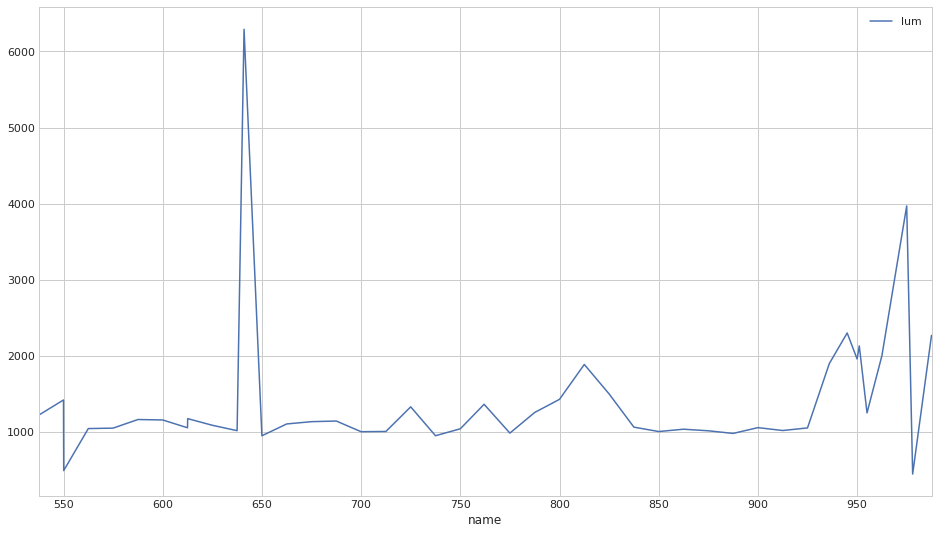

In [333]:
lum.plot(x='name', y='lum')

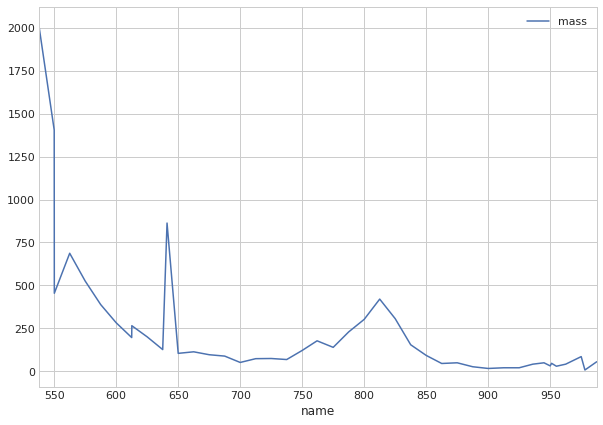

In [77]:
data_prep.groupby('name').agg({'mass':np.size}).plot()

In [337]:
data_prep.groupby('name').agg({'mass':np.size})

,mass
name,
537.5,2022.0
550.0,1405.0
550.1,454.0
562.5,687.0
575.0,525.0
587.5,388.0
600.0,282.0
612.5,196.0
612.6,265.0


Слияние точек

In [335]:
cnct = []
if year=='11':
    cnct = [([875., 887.5], 880), ([900., 912.5, 925.], 910), ([935., 945., 950., 962.5, 975., 987.5, 1000.], 950)] #11year
if year=='12':
    cnct = [([900., 920., 936., 950., 960., 970., 980., 990], 960)] #12 year
if year=='17':
    cnct = [([880., 890., 900., 910.], 900), ([920., 930., 936., 937.5], 935), 
            ([942., 950., 960., 971.], 960), ([981., 990, 1003.5],990)] #17 year
if year=='19':
    cnct = [([875.0, 887.5, 900.0], 875),([945.0, 950.0, 951.1], 950),
            ([955.0, 962.5], 960),([978.0, 987.5], 980)] #19year

In [336]:
for c in cnct:
    data_prep.name.replace(c[0], c[1], inplace=True)

OK, points have been merged

In [338]:
data_prep.tail()

,name,lum,beam_energy,mass,trigger
10575,980.0,2272.43,987.804626,506.214813,2
10576,980.0,2272.43,987.804626,497.718781,2
10577,980.0,2272.43,987.804626,500.018402,2
10578,980.0,2272.43,987.804626,505.620728,2
10579,980.0,2272.43,987.804626,485.108856,2


In [339]:
check_foo(data_prep, data)

Good. 10580 rows


### Пересчитать светимости в слитых точках

In [340]:
data_prep['lume'] = data_prep.beam_energy*data_prep.lum

Проверить правильность слияния

In [341]:
#число в поле lum с количеством элементов в списке для слияния
data_prep[['lum', 'name']].\
drop_duplicates(subset=['lum']).groupby('name').agg({'lum':np.size}).query('lum!=1')

,lum
name,
875.0,3.0
950.0,3.0
960.0,2.0
980.0,2.0


In [342]:
new_lum = data_prep[['beam_energy', 'lum', 'lume', 'name']].\
drop_duplicates(subset=['lum']).groupby('name').agg({'lume':[np.sum], 'lum':[np.sum], 'beam_energy':[np.min, np.max]})

In [343]:
new_lum['Emean'] = np.round( new_lum[('lume','sum')]/new_lum[('lum','sum')], 2)

In [344]:
new_lum.columns = ['lume', 'lum', 'dEmin', 'dEmax', 'Emean']
new_lum.drop('lume', axis=1, inplace=True)
new_lum['dEmax'] = np.abs( np.round( new_lum.dEmax-new_lum.Emean, 2) )
new_lum['dEmin'] = np.abs( np.round( new_lum.Emean - new_lum.dEmin, 2) )

In [345]:
#data.loc[641.].beam_energy.std()

In [346]:
new_lum.query('dEmin>0')

,lum,dEmin,dEmax,Emean
name,,,,
875.0,3065.321,12.94,12.70,887.81
950.0,6400.550,3.70,2.51,948.53
960.0,3259.310,4.16,2.61,960.21
980.0,2723.703,9.67,1.92,985.88


I have got new luminosity table.

Now I should join it to existing table

In [347]:
data_prep.drop(['lume', 'lum', 'beam_energy'], axis=1, inplace=True)

In [348]:
final_data = data_prep.join(new_lum, how='inner', on='name')

In [349]:
check_foo(final_data, data_prep)

Good. 10580 rows


That is good. Now I should do the analysis

In [350]:
final_data.tail()

,name,mass,trigger,lum,dEmin,dEmax,Emean
10575,980.0,506.214813,2,2723.703,9.67,1.92,985.88
10576,980.0,497.718781,2,2723.703,9.67,1.92,985.88
10577,980.0,500.018402,2,2723.703,9.67,1.92,985.88
10578,980.0,505.620728,2,2723.703,9.67,1.92,985.88
10579,980.0,485.108856,2,2723.703,9.67,1.92,985.88


----------------
## Fit

In [351]:
data2 = final_data.groupby('name')

In [352]:
dic = {}
for i in data2.groups:
    print(i)
    dic[i] = np.array( data2.get_group(i)['mass'] )

537.5
550.0
550.1
562.5
575.0
587.5
600.0
612.5
612.6
625.0
637.5
641.0
650.0
662.5
675.0
687.5
700.0
712.5
725.0
737.5
750.0
762.0
775.0
787.5
800.0
812.5
825.0
837.5
850.0
862.5
875.0
912.5
925.0
936.0
950.0
960.0
975.0
980.0


In [353]:
import iminuit
import probfit as pf

In [354]:
plt.rcParams.update({'font.size': 18, 'figure.figsize':(16,9)})

In [355]:
mass_bound = (450, 550)

In [392]:
def constant(x):
    return 1
norm_bkg = pf.Normalized( constant, mass_bound )
norm_bkg = pf.Extended(norm_bkg, extname='$N_{bkg}$')

gauss1 = pf.Extended(pf.rename(pf.gaussian, ['x', 'm', '$\sigma$']), extname='$N_{sig}$')

pdf = pf.AddPdf(gauss1, norm_bkg)
pf.describe(pdf)

['x', 'm', '$\\sigma$', '$N_{sig}$', '$N_{bkg}$']

In [433]:
# limits = {"limit_m": [490, 507], "limit_$\sigma$": [9.1-1.7, 9.01+1.7],  
limits = {"limit_m": [485, 503], "limit_$\sigma$": [3, 11], "limit_$\sigma2$": [1, 15], 
          "limit_$N_{sig}$": [1, 10000], "limit_$N_{bkg}$": [0, 1000]}
errors = {"error_m": 1, "error_$\sigma$": 0.1, "error_$N_{sig}$": 0.3, "error_$N_{bkg}$":0}

In [428]:
def fitter(dic, nbins, binnedLik=False):
    
    norm_bkg = pf.Normalized( constant, mass_bound )
    norm_bkg = pf.Extended(norm_bkg, extname='$N_{bkg}$')
    norm_gauss = pf.AddPdf( pf.rename(pf.gaussian, ['x', 'm', '$\sigma$']), pf.rename(pf.gaussian, ['x', 'm', '$\sigma2$']))
    norm_gauss = pf.Normalized(norm_gauss, mass_bound)
    gauss1 = pf.Extended(norm_gauss, extname='$N_{sig}$')
    pdf = pf.AddPdf(gauss1, norm_bkg)
    
    
    likelihood = pf.UnbinnedLH(pdf, dic, extended=True, extended_bound=mass_bound) if not(binnedLik) else \
    pf.BinnedLH(pdf, dic, int(nbins*(mass_bound[1]-mass_bound[0])/100.), bound=mass_bound, extended=True)
    
    initial_par_values = {"m": 497.6, "$\sigma$": 4.84, "$N_{sig}$": np.size(dic), "$N_{bkg}$": 1, 
                          "$\sigma2$": 5.2}
    mt = iminuit.Minuit(likelihood, **initial_par_values, **errors, **limits, pedantic=False)
    mt.migrad();
    if binnedLik:
        likelihood.draw(minuit=mt)
    else:
        likelihood.draw(minuit=mt, bins=nbins, bound=mass_bound)
    plt.tick_params(labelsize=20);
    plt.xlabel('invariant mass, MeV', fontsize=20)
    plt.ylabel('number of events', fontsize=20)
    #plt.savefig('tutu.svg')
    return mt, likelihood

In [359]:
itr = iter(dic)

In [360]:
fit_frame = pd.DataFrame(columns=[ 'M', 'S', 'N', 'C', 'Merr', 'Serr', 'Nerr', 'Cerr'])

In [419]:
i = next(itr)
print('Label:', i)

Label: 550.0


Migrad quality: True
Real: 1405 Found: 1340.3994023100672


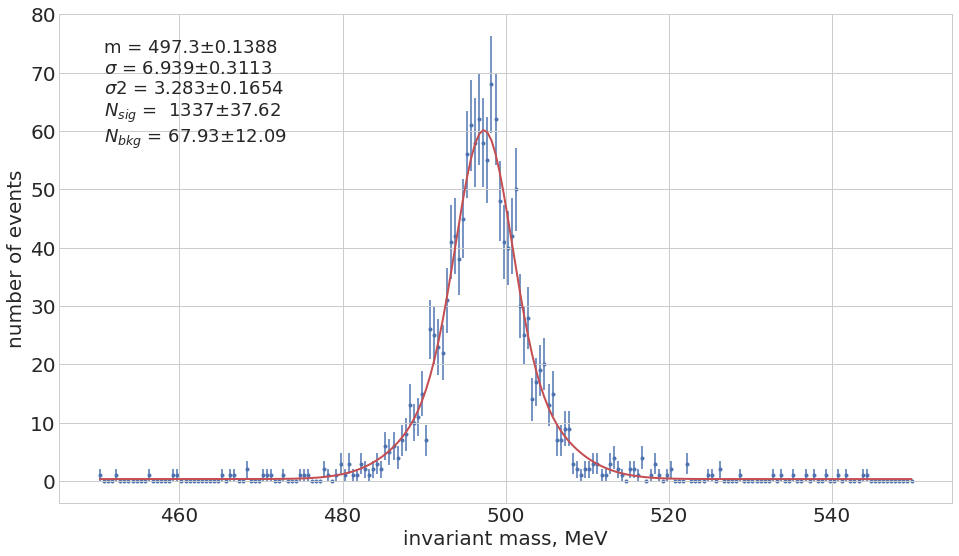

In [442]:
mass_bound = (450, 550)
mt, lik = fitter(final_data.query('name==550.').mass.values, 200, False)#fitter(dic[i], 200, False)
#fit_frame.loc[i] = mt.values.values() + mt.errors.values() 
print("Migrad quality:", mt.migrad_ok())
print( 'Real:', np.size(dic[i]), 'Found:', mt.values[2] + mt.values[3] )

In [408]:
fit_frame

,M,S,N,C,Merr,Serr,Nerr,Cerr
537.5,497.022037,4.521223,1920.086413,101.90531,0.108047,0.092411,44.629657,13.175387


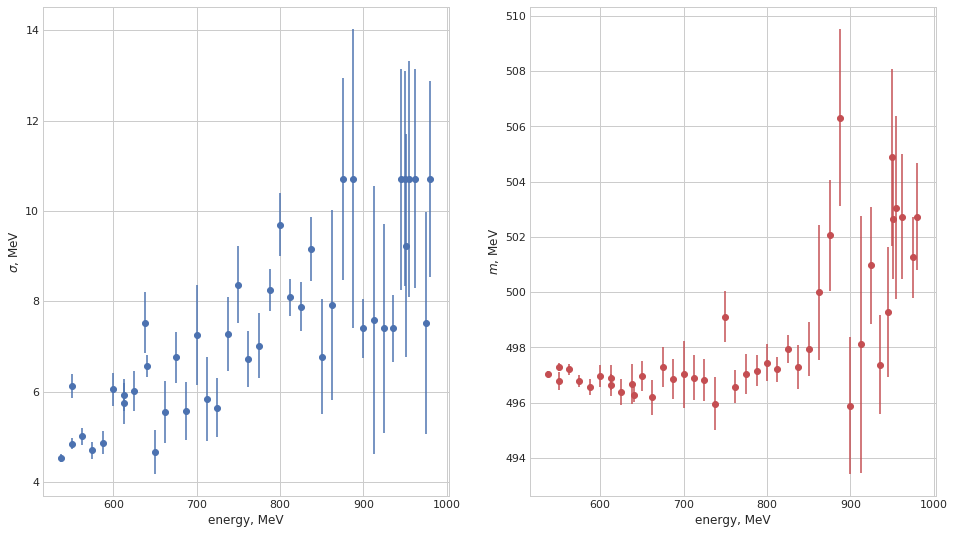

In [327]:
plt.subplot(1, 2, 1)
plt.errorbar(x=fit_frame.index, y=fit_frame.S, yerr=fit_frame.Serr, fmt='o')
plt.xlabel('energy, MeV');
plt.ylabel('$\sigma$, MeV');
plt.subplot(1, 2, 2)
plt.errorbar(x=fit_frame.index, y=fit_frame.M, yerr=fit_frame.Merr, fmt='or')
plt.xlabel('energy, MeV');
plt.ylabel('$m$, MeV');

### Some notes:
none

Save fit info

In [541]:
fit_frame.to_csv(f'../outputs/{year}/tables/fit_frame.csv')

In [249]:
#mt.matrix(correlation=True)
#mt.draw_profile('Nsig');

In [551]:
dataN = fit_frame[['N','Nerr']]
dataN.columns = ['Nsig', 'dNsig']

In [552]:
dataN.tail()

,Nsig,dNsig
939.6,8.512234,3.484017
940.2,3.920473,2.688703
940.8,8.452429,3.676486
960.0,26.657599,5.864628
990.0,15.626607,5.114336


I have got table with events numbers

Now, I will get rid of m-field in the data table (because, I have used it)

In [553]:
data_info = final_data.drop_duplicates(['lum']).drop(['mass', 'trigger'], axis=1).set_index('name')

In [555]:
dataN = data_info.join(dataN, how='inner')
dataN

,lum,dEmin,dEmax,Emean,Nsig,dNsig
name,,,,,,
641.0,3097.960,0.00,0.00,641.02,305.526065,18.672040
650.0,876.635,0.00,0.00,649.77,93.458437,10.024956
675.0,1225.140,0.00,0.00,674.85,81.347338,9.492969
700.0,876.658,0.00,0.00,700.56,27.211716,7.604759
725.0,1114.220,0.00,0.00,724.94,49.241902,8.564588
750.0,1107.580,0.00,0.00,749.55,66.095193,11.465692
775.0,970.862,0.00,0.00,774.85,71.286214,12.712113
800.0,1241.540,0.00,0.00,800.86,110.875385,17.277807
825.0,1381.860,0.00,0.00,825.05,129.607395,17.256661


In [558]:
check_foo(dataN, fit_frame)

Good. 23 rows


OK, save it

In [559]:
dataN.to_csv(f'../outputs/{year}/tables/signal_table{year}.csv', float_format='%.2f')

Ok, now about triggers

In [573]:
triggers = final_data[['trigger','name']].set_index('name')
triggers = triggers.assign(one = 1);

In [574]:
triggers

,trigger,one
name,,
641.0,2,1
641.0,2,1
641.0,2,1
641.0,2,1
641.0,0,1
...,...,...
990.0,2,1
990.0,2,1
990.0,2,1


In [575]:
check_foo(triggers, final_data)

Good. 1776 rows


In [576]:
triggers = pd.pivot_table(triggers, values='one', columns=['trigger'], index='name', aggfunc=np.sum).fillna(0)

In [577]:
triggers.columns = ['TF', 'CF', 'TC']

In [578]:
triggers.head()

,TF,CF,TC
name,,,
641.0,83.0,4.0,258.0
650.0,13.0,0.0,87.0
675.0,25.0,4.0,64.0
700.0,11.0,1.0,31.0
725.0,13.0,2.0,49.0


In [579]:
def variance(k, n):
    return (k+1)*(k+2)/(n+2)/(n+3) - (k+1)**2/(n+2)**2

In [580]:
triggers['eTF'] = (triggers['TC'] + 1)/(triggers['CF'] + triggers['TC'] + 2)
triggers['eCF'] = (triggers['TC'] + 1)/(triggers['TF'] + triggers['TC'] + 2)
triggers['TrigEff'] = 1 - (1-triggers['eTF'])*(1-triggers['eCF'])

triggers['vTF'] = np.sqrt( variance(triggers['TC'], triggers['CF'] + triggers['TC']) )
triggers['vCF'] = np.sqrt( variance(triggers['TC'], triggers['TF'] + triggers['TC']) )
triggers['TrigErr'] = np.sqrt( np.square((1-triggers['eTF'])*triggers['vCF']) + 
                              np.square((1-triggers['eCF'])*triggers['vTF']) )

OK, trigers have been got

In [583]:
check_foo(triggers, dataN)

Good. 23 rows


In [581]:
triggers.to_csv(f'../outputs/{year}/tables/triggers{year}.csv', float_format='%.2f')

In [582]:
triggers

,TF,CF,TC,eTF,eCF,TrigEff,vTF,vCF,TrigErr
name,,,,,,,,,
641.0,83.0,4.0,258.0,0.981061,0.755102,0.995362,0.008374,0.023185,0.002097
650.0,13.0,0.0,87.0,0.988764,0.862745,0.998458,0.011110,0.033907,0.001572
675.0,25.0,4.0,64.0,0.928571,0.714286,0.979592,0.030564,0.047099,0.009358
700.0,11.0,1.0,31.0,0.941176,0.727273,0.983957,0.039772,0.066391,0.011529
725.0,13.0,2.0,49.0,0.943396,0.781250,0.987618,0.031447,0.051276,0.007466
750.0,24.0,3.0,75.0,0.950000,0.752475,0.987624,0.024216,0.042732,0.006364
775.0,20.0,2.0,85.0,0.966292,0.803738,0.993384,0.019024,0.038218,0.003950
800.0,36.0,3.0,133.0,0.971014,0.783626,0.993728,0.014230,0.031397,0.003211
825.0,49.0,2.0,146.0,0.980000,0.746193,0.994924,0.011393,0.030928,0.002957
